In this notebook, we load the files in the data folder and rename them

Let's do gene DDB2: 0.92 AUC with the classifier

In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model
from keras import metrics


import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


list_not_dir = ['gdc_manifest_20170512_072412.txt', 'test.svs', 'y_train.txt', 'gdc-client']

Using TensorFlow backend.


In [2]:
#import shutil
#for filename in os.listdir("/home/cedoz/radiogenomics/data/"):
#    if filename not in list_not_dir:
#        if filename[-3:] != "svs":
#            my_path = "/home/cedoz/radiogenomics/data/%s"%filename
#            svs_image = [f for f in os.listdir(my_path) if os.path.isfile(os.path.join(my_path, f)) if f != "annotations.txt"]
#            os.chdir(my_path)
#            if svs_image != []:
#                if len(str(svs_image[0]>12)):
#                    os.rename(svs_image[0], svs_image[0][:12] + ".svs")
#                    shutil.move(svs_image[0][:12] + ".svs", os.path.join("/home/cedoz/radiogenomics/data/", svs_image[0][:12] + ".svs"))
#            shutil.rmtree(my_path)
#os.chdir("/home/cedoz/radiogenomics/")

In [5]:
import random

y_train_global = {}
with open("data/y_train.txt") as f:
    for line in f:
        (key, val) = line.split()
        key = str(key).replace('.','-')
        y_train_global[key] = int(val)

svs_images = []
for filename in os.listdir("/home/cedoz/radiogenomics/data/"):
    if filename not in list_not_dir:
        svs_images.append(filename[:-4])
        
#intersect_samples = [val for val in svs_images if val in y_train_global.keys()]
#random.shuffle(intersect_samples)
#np.save("intersect_samples.npy", intersect_samples)

intersect_samples = np.load("intersect_samples.npy")

In [7]:
np.array(([y_train_global[filename] for filename in intersect_samples]))

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1,

In [37]:
low_resolution = False
high_resolution = True
rebuild = False
test_size = 0.3

if rebuild:
    filenames = os.listdir("/home/cedoz/radiogenomics/preprocessed/")
    np.random.shuffle(filenames)
    train_filenames = filenames[:int(len(filenames)*(1-test_size))]
    test_filenames = filenames[int(len(filenames)*(1-test_size)):]
    X_train = np.zeros((1,224,224,3))
    y_train = np.zeros((1,1))
    X_test = {}
    y_test = np.array(([y_train_global[filename[2:-4]] for filename in test_filenames]))
    
    if low_resolution:
        print("processing low resolution images...")
    if high_resolution:
        print("processing high resolution images...")
    
    count = 0
    for filename in train_filenames:
        count +=1
        print("processing train sample %d out of %d"%(count, len(train_filenames)))
        X = np.load("preprocessed/%s"%filename)
        new_X = np.zeros((X.shape[0],224,224,3))
        if low_resolution:
            for idx in range(X.shape[0]):
                patch = np.int8(X[idx])
                patch = Image.fromarray(patch, 'RGB')
                patch.thumbnail((224,224))
                new_X[idx] = np.array(patch.getdata()).reshape((224,224,3))
        if high_resolution:
            for idx in range(X.shape[0]):
                #Select a small patch in the middle of the image
                new_X[idx] = X[idx][335:559,335:559,:]              
        new_y = y_train_global[filename[2:-4]]*np.ones((new_X.shape[0],1))
        X_train = np.append(X_train, new_X, axis=0)
        y_train = np.append(y_train, new_y, axis=0)
    X_train = X_train[1:]
    y_train = y_train[1:]
    
    count = 0
    for filename in test_filenames:  
        count +=1
        print("processing test sample %d out of %d"%(count, len(train_filenames)))
        X = np.load("preprocessed/%s"%filename)
        new_X = np.zeros((X.shape[0],224,224,3))
        if low_resolution:
            for idx in range(X.shape[0]):
                patch = np.int8(X[idx])
                patch = Image.fromarray(patch, 'RGB')
                patch.thumbnail((224,224))
                new_X[idx] = np.array(patch.getdata()).reshape((224,224,3))
        if high_resolution:
            for idx in range(X.shape[0]):
                #Select a small patch in the middle of the image
                new_X[idx] = X[idx][335:559,335:559,:] 
        X_test[filename] = new_X
    
    if low_resolution:
        np.save("X_low_resolution.npy", X_train)
        np.save("y_low_resolution.npy", y_train)    
        np.save("X_test_low_resolution.npy", X_test)
        np.save("y_test_low_resolution.npy", y_test)
    if high_resolution:
        np.save("X_high_resolution.npy", X_train)
        np.save("y_high_resolution.npy", y_train)    
        np.save("X_test_high_resolution.npy", X_test)
        np.save("y_test_high_resolution.npy", y_test)

if low_resolution:
    X = np.load("X_low_resolution.npy")
    y = np.load("y_low_resolution.npy")
    X_test = np.load("X_test_low_resolution.npy").item()
    y_test = np.load("y_test_low_resolution.npy")
if high_resolution:
    X = np.load("X_high_resolution.npy")
    y = np.load("y_high_resolution.npy")
    X_test = np.load("X_test_high_resolution.npy").item()
    y_test = np.load("y_test_high_resolution.npy")


In [38]:
from sklearn.model_selection import train_test_split

X_train, _, y_train, _ = train_test_split(X, y, test_size=0, random_state=0)

print(X_train.shape, y_train.shape)
print(len(X_test), y_test.shape)

#for filename in os.listdir("/home/cedoz/radiogenomics/preprocessed/"):
#    print (y_train[filename[2:-4]])

(2769, 224, 224, 3) (2769, 1)
5 (5,)


# Deep Learning

## Inception V3

In [71]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, pooling = 'avg', input_shape = (224,224,3))
x = base_model.output
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
logits = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=logits)

for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
adam = Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics = ['accuracy'])

history1 = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

model.save('models/InceptionV3_inter_3e-4.h5')

Train on 2215 samples, validate on 554 samples
Epoch 1/10
2215/2215 [==============================] - 27s - loss: 0.4573 - acc: 0.7725 - val_loss: 1.6416 - val_acc: 0.4711
Epoch 2/10
2215/2215 [==============================] - 25s - loss: 0.3154 - acc: 0.8718 - val_loss: 1.5787 - val_acc: 0.5126
Epoch 3/10
2215/2215 [==============================] - 25s - loss: 0.2132 - acc: 0.9156 - val_loss: 0.3672 - val_acc: 0.8430
Epoch 4/10
2215/2215 [==============================] - 25s - loss: 0.2688 - acc: 0.8935 - val_loss: 0.2349 - val_acc: 0.9043
Epoch 5/10
2215/2215 [==============================] - 25s - loss: 0.1885 - acc: 0.9255 - val_loss: 0.1176 - val_acc: 0.9567
Epoch 6/10
2215/2215 [==============================] - 25s - loss: 0.1914 - acc: 0.9192 - val_loss: 0.1271 - val_acc: 0.9549
Epoch 7/10
2215/2215 [==============================] - 25s - loss: 0.1588 - acc: 0.9377 - val_loss: 0.1346 - val_acc: 0.9477
Epoch 8/10
2215/2215 [==============================] - 25s - loss: 0.1

In [ ]:
#Fine tune the two previous inception layers
model = load_model('models/InceptionV3_inter_3e-4.h5')

for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

adam = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics = ['accuracy'])

history2 = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2)
model.save('models/InceptionV3_final_3e-4_1e-6.h5')

## ResNet50

In [ ]:
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, pooling = 'avg', input_shape = (224,224,3))
x = base_model.output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
logits = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=logits)

for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
adam = Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics = ['accuracy'])

history1 = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2)

model.save('models/ResNet50_inter_3e-4.h5')

In [ ]:
#Fine tune the two previous residual layers

model = load_model('models/ResNet50_inter_3e-4.h5')

for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

adam = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics = ['accuracy'])

history2 = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2)
model.save('models/InceptionV3_final_3e-4_5e-6.h5')

## Plot learning curves

dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])


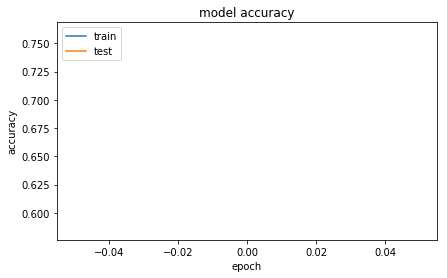

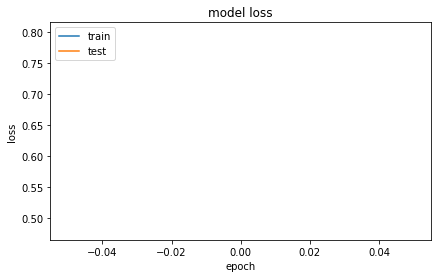

In [55]:
history = history1
# list all data in history
print(history.history.keys())

plt.figure(figsize = (15,4))

# summarize history for accuracy
ax1 = plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize = (15,4))

# summarize history for loss
ax2 = plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model evaluation on the test set

In [73]:
test_filenames = X_test.keys()
y_test = np.array(([y_train_global[filename[2:-4]] for filename in test_filenames]))
y_pred = []
for filename in test_filenames:
    y_preds = model.predict(X_test[filename], batch_size=32, verbose=1)
    print(np.mean(y_preds))
    y_pred.append((int(np.mean(y_preds>0.5)>0.5)))
test_accuracy = np.mean(y_pred == y_test)
test_accuracy

33/33 [==============================] - 0s     
0.305878
139/139 [==============================] - 1s     
0.271353
229/229 [==============================] - 2s     
0.169462
401/401 [==============================] - 3s     
0.224489
379/379 [==============================] - 3s     
0.74545


0.59999999999999998

In [85]:
print(y_test)

[1 0 1 0 1]
